# Image Classification

Classification of Fashion MNIST dataset using tensorflow neural network models: DNN & CNN.

There are 70,000 images in the dataset - 60,000 in the training set and 10,000 in the test set. 

Each image is 28 x 28 pixels, grayscale.

In [1]:
import warnings
# import libraries
import tensorflow as tf
import warnings
import logging

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.10.0


In [2]:
warnings.filterwarnings("ignore")
# tfds.disable_progress_bar()
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
#set random seeds
np.random.seed(42)
tf.random.set_seed(1234)

## MNIST Dataset

In [3]:
# load fashion MNIST dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

### Explore the data

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print(f"Number of examples in training dataset: {num_train_examples}")
print(f"Number of exaples in tet dataset {num_test_examples} ")
print("Number of classes: {}".format(metadata.features['label'].num_classes))

class_names = metadata.features['label'].names
print("---------------------")
print("Label\tClass")
print("---------------------")
for ind, name in enumerate(class_names):
  print(f"{ind}\t {name}")
print("---------------------")

Number of examples in training dataset: 60000
Number of exaples in tet dataset 10000 
Number of classes: 10
---------------------
Label	Class
---------------------
0	 T-shirt/top
1	 Trouser
2	 Pullover
3	 Dress
4	 Coat
5	 Sandal
6	 Shirt
7	 Sneaker
8	 Bag
9	 Ankle boot
---------------------


### Data preprocessing

In [5]:
# data normalization
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# the map function applied normalize fuction to each element in the train 
# and test datasets
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

# the first time images are loaded from the disk, which is slow
# caching keeps the images in memory for faster training of the models
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

### Explore the processed data

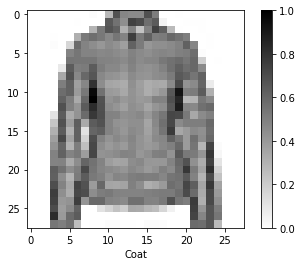

In [6]:
# display a single image from the test dataset
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.xlabel(class_names[label])
plt.grid(False)
plt.colorbar()
plt.show()

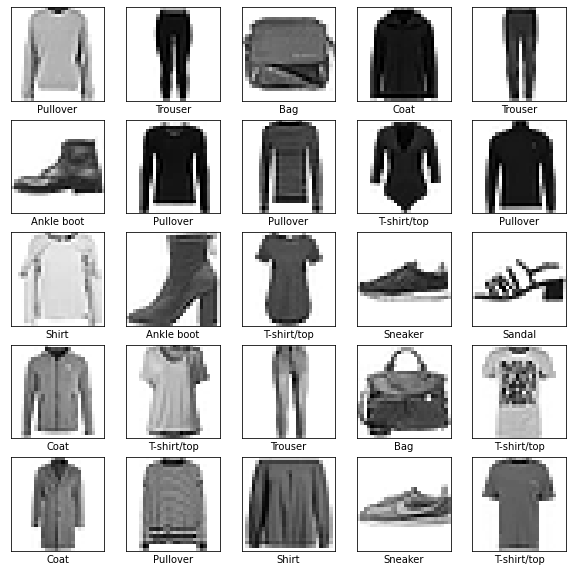

In [7]:
# display the first 25 images from the training dataset alongwith their labels
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

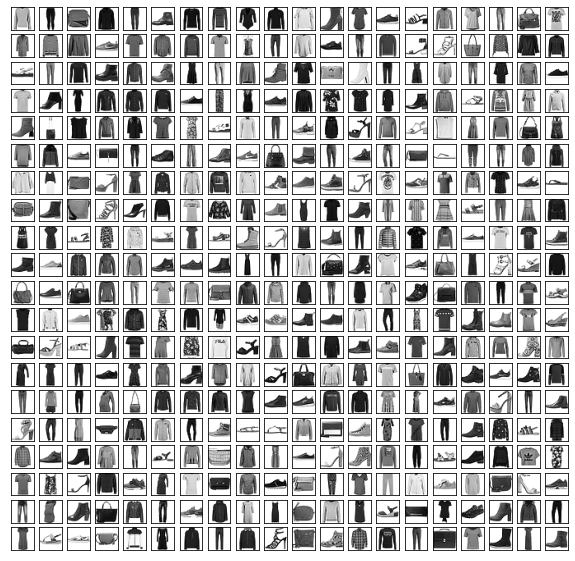

In [8]:
# display a mosaic of images
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(400)):
  image = image.numpy().reshape((28,28))
  plt.subplot(20,20,i+1)
  plt.imshow(image, cmap=plt.cm.binary)
  # plt.xlabel(class_names[label])
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
plt.show()

### Prepare the batch data

In [9]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

## DNN model
Built a model using fully connected dense layers `tf.keras.layers.Dense`

In [10]:
model_dnn = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [11]:
# compile the model
model_dnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model architecture
tf.keras.utils.plot_model(model_dnn, 'model_dnn.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
# train the model
epochs = 5
history = model_dnn.fit(train_dataset, epochs=epochs, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
1875/1875 [==============================] - 9s 2ms/step - loss: 0.4927 - accuracy: 0.8266
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3740 - accuracy: 0.8650
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3278 - accuracy: 0.8804
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3081 - accuracy: 0.8872
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2985 - accuracy: 0.8892


### Evaluate the model
Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

In [14]:
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on the test dataset: %.2f%%' % (test_accuracy_dnn*100))

313/313 [==============================] - 2s 4ms/step - loss: 0.3766 - accuracy: 0.8676
Accuracy on the test dataset: 86.76%


### Visualize model training

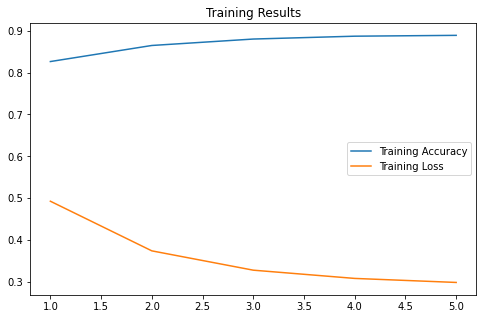

In [16]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, (epochs+1))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='center right')
plt.title('Training Results')

plt.show()

### Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [17]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions_dnn = model_dnn.predict(test_images)
predictions_dnn.shape

1/1 [==============================] - 0s 147ms/step


(32, 10)

In [18]:
predictions_dnn[0]

array([9.1313035e-05, 2.5595298e-05, 1.4971417e-02, 6.4299429e-06,
       9.7395146e-01, 5.4886738e-07, 1.0684218e-02, 3.3983070e-09,
       2.6899713e-04, 4.7127511e-08], dtype=float32)

A prediction is an array of 10 numbers. These describe the "confidence" of the model that the image corresponds to each of the 10 different articles of clothing. We can see which label has the highest confidence value:

In [19]:
np.argmax(predictions_dnn[0])

4

So the model is most confident that this image is a `Coat`, or class_names[4]. And we can check the test label to see this is correct:

In [20]:
print(f"Label: {test_labels[0]}")
print(f"Class: {class_names[test_labels[0]]}")

Label: 4
Class: Coat


We can graph this to look at the full set of 10 class predictions

In [21]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array.

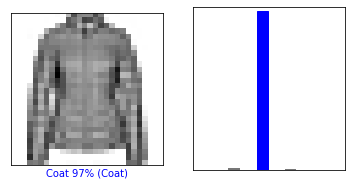

In [22]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions_dnn, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions_dnn, test_labels)

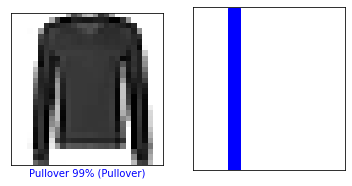

In [23]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions_dnn, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions_dnn, test_labels)

Let's plot several images with their predictions. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label. Note that it can be wrong even when very confident.

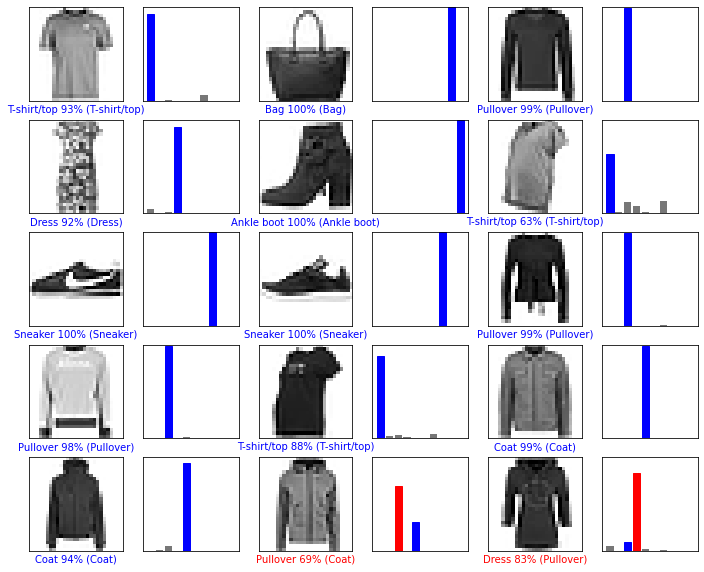

In [27]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
start = 10
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image((start+i), predictions_dnn, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array((start+i), predictions_dnn, test_labels)

Finally, use the trained model to make a prediction about a single image.

In [28]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


`tf.keras` models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

In [29]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


Now predict the batch containing a single image

In [31]:
predictions_single = model_dnn.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 41ms/step
[[9.1312955e-05 2.5595249e-05 1.4971417e-02 6.4299370e-06 9.7395146e-01
  5.4886527e-07 1.0684218e-02 3.3983070e-09 2.6899661e-04 4.7127511e-08]]


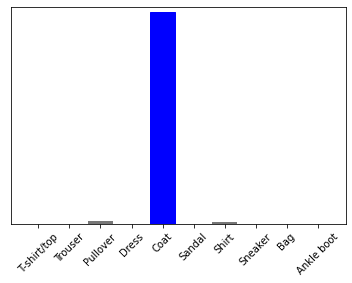

In [32]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

`model.predict` returns a list of lists, one for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [33]:
np.argmax(predictions_single[0])

4

And, as before, the model predicts a label of 4 (coat).

### Save the model
To use the trained model with on-device applications, first convert it to a smaller and more efficient model format called a TensorFlow Lite model.

To do this, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a TensorFlow Lite model:

In [34]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model_dnn)
tflite_model = converter.convert()

# Save the model.
with open('model_dnn.tflite', 'wb') as f:
  f.write(tflite_model)

### Run the TensorFlow Lite model
You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter class`.

Load the model with the Interpreter:

In [36]:
TF_MODEL_FILE_PATH = 'model_dnn.tflite' # The default path to the saved TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

#Print the signatures from the converted model to obtain the names of the inputs (and outputs):
interpreter.get_signature_list()

{'serving_default': {'inputs': ['flatten_input'], 'outputs': ['dense_1']}}

In this example, we have one default signature called serving_default. In addition, the name of the 'inputs' is 'flatten_input', while the 'outputs' are called 'dense_1'. We can look up these first and last Keras layer names when running Model.summary.

Now we can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [37]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what we did earlier in the tutorial, we can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

We have already tensorized that image and saved it as `img`. Now, pass it to the first argument (the name of the 'inputs') of the loaded TensorFlow Lite model (predictions_lite), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [38]:
predictions_lite = classify_lite(flatten_input=img)['dense_1']
#score_lite = tf.nn.softmax(predictions_lite)
score_lite = predictions_lite

assert np.allclose(predictions_single, predictions_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to Coat with a 97.40 percent confidence.


The loaded model predicts label 4 (Coat) as before which is correct.

## CNN Model

In [86]:
# build the model
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, 
                           input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)
])

In [87]:
# complile the model
model_cnn.compile(optimizer='adam', 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])
model_cnn.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_6 (Flatten)         (None, 3136)             

In [88]:
# model architecture
tf.keras.utils.plot_model(model_cnn, 'model_cnn.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [89]:
# callbacks
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [90]:
# train the model
epochs = 10
history = model_cnn.fit(train_dataset, epochs=epochs, 
                        validation_data=test_dataset,
                        callbacks=callbacks,
                        steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 95s 50ms/step - loss: 0.4094 - accuracy: 0.8508 - val_loss: 0.3128 - val_accuracy: 0.8864
Epoch 2/10
1875/1875 [==============================] - 93s 50ms/step - loss: 0.2715 - accuracy: 0.9015 - val_loss: 0.2716 - val_accuracy: 0.8980
Epoch 3/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.2274 - accuracy: 0.9154 - val_loss: 0.2657 - val_accuracy: 0.9043
Epoch 4/10
1875/1875 [==============================] - 93s 50ms/step - loss: 0.1972 - accuracy: 0.9267 - val_loss: 0.2601 - val_accuracy: 0.9061
Epoch 5/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1738 - accuracy: 0.9356 - val_loss: 0.2377 - val_accuracy: 0.9175
Epoch 6/10
1875/1875 [==============================] - 92s 49ms/step - loss: 0.1550 - accuracy: 0.9417 - val_loss: 0.2428 - val_accuracy: 0.9157
Epoch 7/10
1875/1875 [==============================] - 93s 49ms/step - loss: 0.1400 - accuracy: 0.9474 - val_loss: 0.2436 -

### Evaluate the model

In [91]:
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print('Accuracy on test dataset: %.2f%%' % (test_accuracy_cnn*100))

313/313 [==============================] - 4s 12ms/step - loss: 0.2626 - accuracy: 0.9216
Accuracy on test dataset: 92.16%


In [92]:
epochs = len(history.history['loss'])

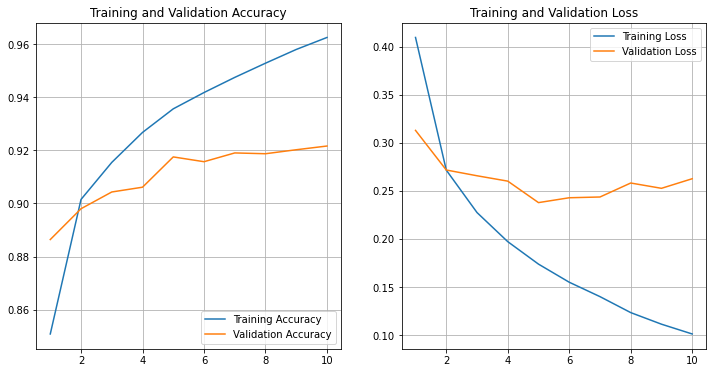

In [93]:
# visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, epochs+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()

plt.show()

### Make predictions and explore
With the model trained, we can use it to make predictions about some images.

In [94]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions_cnn = model_cnn.predict(test_images)
predictions_cnn.shape

1/1 [==============================] - 0s 158ms/step


(32, 10)

In [95]:
predictions_cnn[0]

array([ -6.985885  , -12.159282  ,  -0.18779704, -11.672967  ,
         2.4726539 , -12.986295  ,   2.7689004 , -10.697598  ,
       -11.302169  ,  -7.977617  ], dtype=float32)

In [109]:
np.argmax(predictions_cnn[1])

4

In [111]:
# test_labels[1]
score = tf.nn.softmax(predictions_cnn[1])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Coat with a 97.01 percent confidence.


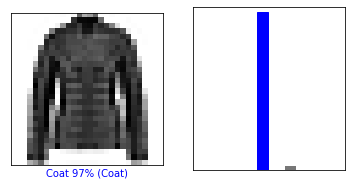

In [112]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, tf.nn.softmax(predictions_cnn), test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, tf.nn.softmax(predictions_cnn), test_labels)

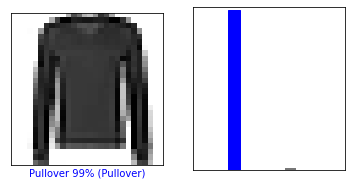

In [114]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, tf.nn.softmax(predictions_cnn), test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, tf.nn.softmax(predictions_cnn), test_labels)

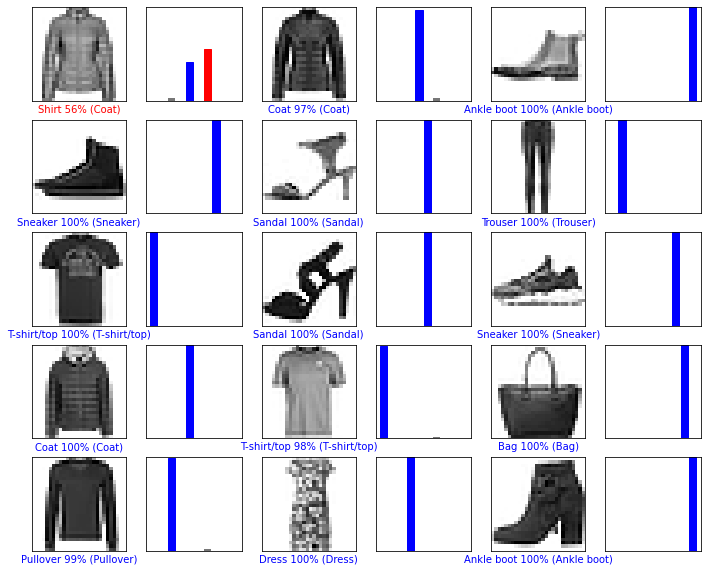

In [115]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, tf.nn.softmax(predictions_cnn), test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, tf.nn.softmax(predictions_cnn), test_labels)

In [121]:
# Grab an image from the test dataset
img = test_images[1]

print(img.shape)

(28, 28, 1)


In [122]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [127]:
# now predict the single image
predictions_single = model_cnn.predict(img)
scores = tf.nn.softmax(predictions_single)
print(scores)

1/1 [==============================] - 0s 66ms/step
tf.Tensor(
[[3.7021703e-06 1.1428352e-09 9.7765692e-04 1.6280531e-08 9.7011763e-01
  7.1474004e-09 2.8901031e-02 1.7047845e-10 2.7883307e-10 2.5820304e-08]], shape=(1, 10), dtype=float32)


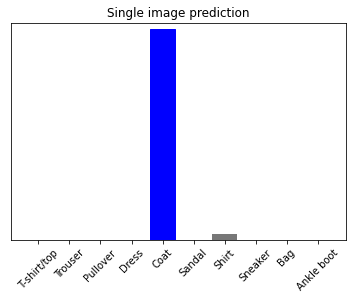

In [137]:
# plot the single image class probability distribution
plot_value_array(0, scores, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
_ = plt.title("Single image prediction")

In [129]:
np.argmax(predictions_single)

4

### Save the model

In [136]:
model_cnn.save('model_cnn')

### Load the model & make predictions

In [131]:
loaded_model_cnn = tf.keras.models.load_model('model_cnn')

In [134]:
# now predict the single image with the loaded model
predictions_single = loaded_model_cnn.predict(img)
scores_with_loaded_cnn = tf.nn.softmax(predictions_single)
print(scores)

1/1 [==============================] - 0s 62ms/step
tf.Tensor(
[[3.7021703e-06 1.1428352e-09 9.7765692e-04 1.6280531e-08 9.7011763e-01
  7.1474004e-09 2.8901031e-02 1.7047845e-10 2.7883307e-10 2.5820304e-08]], shape=(1, 10), dtype=float32)


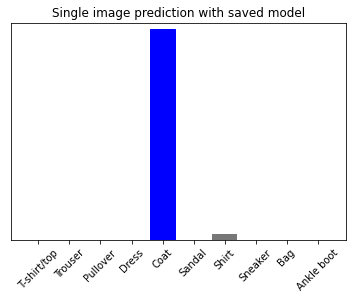

In [138]:
# plot the single image class probability distribution
plot_value_array(0, scores_with_loaded_cnn, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)
_ = plt.title("Single image prediction with saved model")

It works!